Overview:
(some text regarding the purpose of this project, overall approach and a the hypothesis/qs)

Phase 1- 
Importing libraries and datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
#import seaborn as sns

In [4]:
movie_gross = pd.read_csv('./zippedData/bom.movie_gross.csv.gz')
name_basics = pd.read_csv('./zippedData/imdb.name.basics.csv.gz')
title_akas = pd.read_csv('./zippedData/imdb.title.akas.csv.gz')
title_basics = pd.read_csv('./zippedData/imdb.title.basics.csv.gz')
#on inspection, we didn't find the following datasets relevant to our hypotheses
#title_crew = pd.read_csv('./zippedData/imdb.title.crew.csv.gz')
#title_principals = pd.read_csv('./zippedData/imdb.title.principals.csv.gz')
title_ratings = pd.read_csv('./zippedData/imdb.title.ratings.csv.gz')
movie_info= pd.read_csv('./zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews= pd.read_csv('./zippedData/rt.reviews.tsv.gz', sep='\t', encoding='windows-1254')
budgets = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz')

Phase 2-
Data cleaning, ordering and merging the datasets

In [5]:
#converting all values in budgets sheets to ints by removing commas and $
budgets['domestic_gross'] = budgets['domestic_gross'].astype(str)
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$' , '')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',', '')
budgets['domestic_gross'] = budgets['domestic_gross'].astype(int)

budgets['production_budget'] = budgets['production_budget'].astype(str)
budgets['production_budget'] = budgets['production_budget'].str.replace('$' , '')
budgets['production_budget'] = budgets['production_budget'].str.replace(',', '')
budgets['production_budget'] = budgets['production_budget'].astype(int)

budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(str)
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$' , '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',', '')
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)
#converting release dates to datetime format
budgets.release_date = pd.to_datetime(budgets['release_date'])
#adding a column in month format for easier graphing
budgets['release_month'] = budgets['release_date'].dt.strftime("%m%d")

In [6]:
#creating new lines showing the difference between gross and cost, aka net, as well as a profit percentage calculation showing net over budget
budgets['domestic_net']= budgets['domestic_gross']- budgets['production_budget']
budgets['worldwide_net']= budgets['worldwide_gross']- budgets['production_budget']
budgets['profit_percentage'] = (budgets['worldwide_net']/budgets['production_budget'])*100

In [7]:
#The movies in the budget sheet start in 1915 and will definitely pull the spread of our dataset way down, particularly as we measure revenue
budgets.release_date.sort_values().unique()
#dropping all values of movies made before 1995- this excludes about 700 rows with dates from 1915-1995 and leaves 5000
budgets = budgets[~budgets['release_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]
#renaming the title column in preparation for merge
budgets.rename(columns= {'movie': 'primary_title'}, inplace= True)

In [8]:
#combining ratings and basics to produce a dataframe that matches titles to ratings
titlerate = title_ratings.merge(title_basics, on= 'tconst', how= 'outer')
#dropping null values from the combined table
titlerate.dropna(subset= ['averagerating'], inplace = True)
titlerate.dropna(subset = ['genres'], inplace = True)
#converting the genres column to lists
titlerate.genres = titlerate.genres.apply(lambda x: re.split(",",x) if isinstance(x,str) else x)
#iterating through the lists and seperating at commas, not sure why that didn't work above
for i in list(range(len(titlerate.genres))):
    try:
        if  type(titlerate.genres[i][0]) == str:
            titlerate.genres[i][0].split(',')
    except KeyError:
        i +=1
        continue

In [9]:
#aggregating reviews in the rt_reviews set by replacing 'fresh' and 'rotten' with 1 and 0 respectively, then generating an average and using it as a rating system
rt_reviews['fresh_index'] = rt_reviews['fresh'].replace('fresh', 1).replace('rotten', 0)
rt_reviews['fresh_average'] = rt_reviews.groupby(['id'])['fresh_index'].mean()
rt_reviews.dropna(subset= ['fresh_average'], inplace = True)
#adding the freshness average to the movie_info sheet, as the reviews one is about 50,000 lines long and has little useful data
movie_info['freshness'] = rt_reviews.fresh_average

In [10]:
#changing the theater dates to datetime format so we can measure revenue against release date
movie_info['theater_date'] = pd.to_datetime(movie_info['theater_date'])
#dropping dates before 1995 in order to focus on relevant data
movie_info = movie_info[~movie_info['theater_date'].isin(pd.date_range(start='1915-01-01', end='1995-12-31'))]
#dropping the dvd date column to avoid confusion
movie_info.drop(['dvd_date'], axis = 1, inplace = True)
#reformatting the box office numbers to ints
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')

In [11]:
#since all currency seems to be in dollars we don't need to bother with a conversion here
movie_info.currency.unique()

array(['$', nan], dtype=object)

In [12]:
#splitting the genres in movie info
movie_info['genres']=movie_info.genre.apply(lambda x: re.split("and|\|",x) if isinstance(x,str) else x)
#dropping NAs from genres
movie_info.dropna(subset = ['genres'], inplace = True)

In [13]:
# merging the cleaned dataframes
maindf = budgets.merge(titlerate, on= 'primary_title', how= 'inner')

Phase 3- 
Graphing and examining the datasets

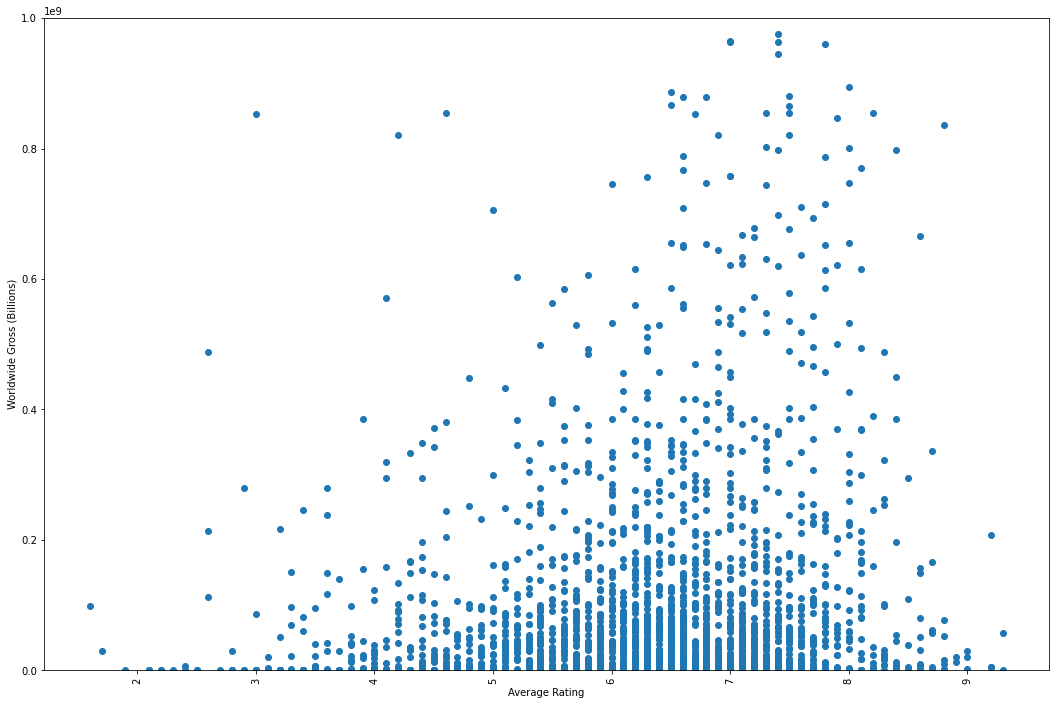

In [14]:
#this looks promising in terms of returning as usable conclusion
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf.averagerating
y= maindf.worldwide_gross 

ax.set_xlabel('Average Rating')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1000000000)
plt.xticks(rotation= 90)
plt.scatter(x, y)

<BarContainer object of 2710 artists>

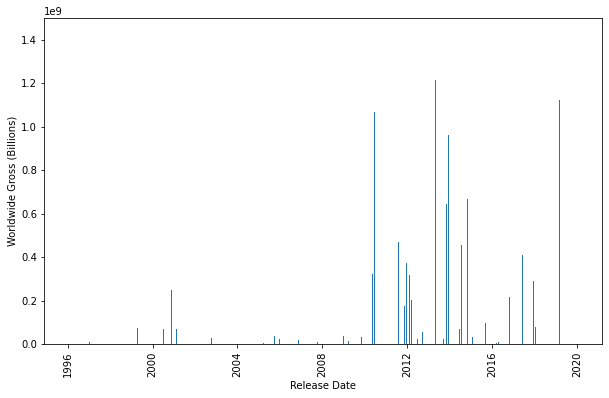

In [15]:
#plotting worldwide gross for our selected time period. There are some pretty obvious peaks and valleys, just need to get into the year over year and follow the trends. I cropped out the outlier data above $1.5bn to show more granular spread 
fig, ax = plt.subplots(figsize= (10, 6))
x= maindf['release_date']
y= maindf.worldwide_gross 

ax.set_xlabel('Release Date')
ax.set_ylabel('Worldwide Gross (Billions)')
ax.set_ylim(0, 1500000000)
plt.xticks(rotation= 90)
plt.bar(x, y)

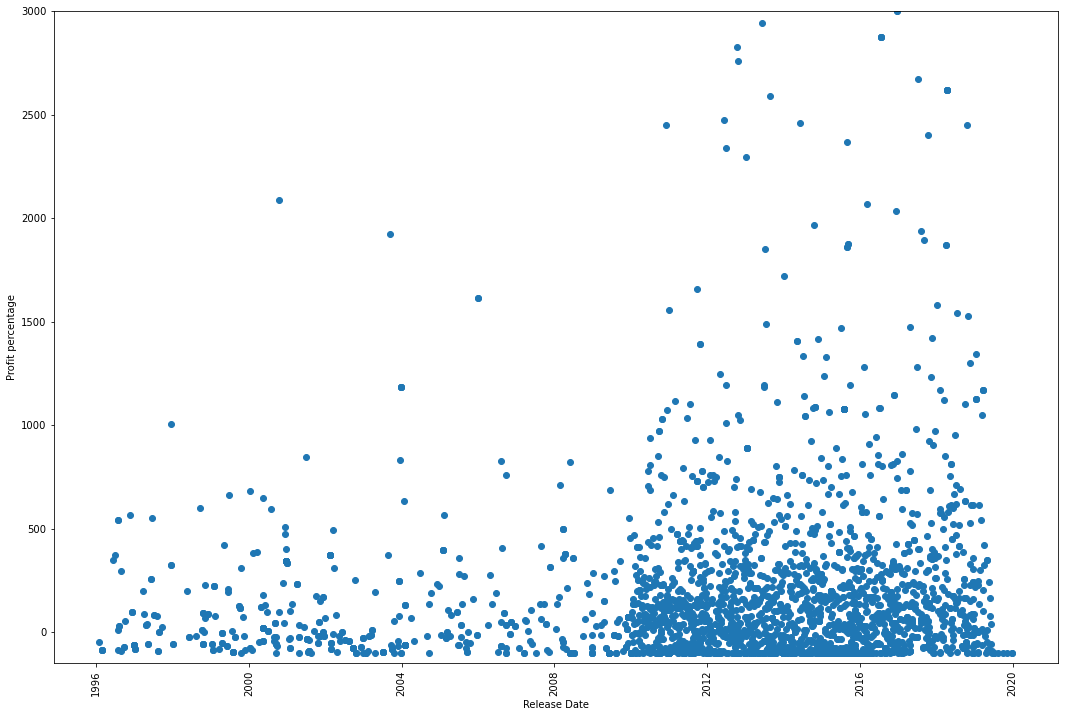

In [16]:
#a profitability scatter plot- note that I shifted the y limit to -150 to show loss. The top limit has a lot of outliers far beyond the top which flattened the graph if I didn't exclude them. This graph is a lot more difficult to interpret
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['release_date']
y= maindf.profit_percentage

ax.set_xlabel('Release Date')
ax.set_ylabel('Profit percentage')
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x, y)

In [17]:
#here we see there is no correlation between initial production budget and profitability, which I think is our first noteworthy finding
budgets.corrwith(budgets['production_budget'])

id                  -0.034465
production_budget    1.000000
domestic_gross       0.723568
worldwide_gross      0.767943
domestic_net         0.133475
worldwide_net        0.634965
profit_percentage   -0.038473
dtype: float64

In [18]:
masterlist = movie_info.genres.explode()

In [19]:
for i in masterlist:
    i.strip()

In [20]:
masterlist.value_counts()

Drama               565
Comedy              332
 Adventure          212
Action              212
Mystery             194
 Suspense           194
 International      159
Art House           159
Romance             103
Science Fiction      92
 Fantasy             92
Horror               78
Kids                 61
 Family              61
Documentary          57
Special Interest     47
 Performing Arts     46
Musical              46
Animation            38
Classics             24
Western              20
Television           18
 Spirituality         8
Faith                 8
 Fitness              7
Sports                7
Anime                 2
 Manga                2
Cult Movies           1
Name: genres, dtype: int64

In [21]:
masterlist1 = titlerate.genres.explode()

In [22]:
masterlist1.value_counts()

Drama          30788
Documentary    17753
Comedy         17290
Thriller        8217
Horror          7674
Action          6988
Romance         6589
Crime           4611
Adventure       3817
Biography       3809
Family          3412
Mystery         3039
History         2825
Sci-Fi          2206
Fantasy         2126
Music           1968
Animation       1743
Sport           1179
War              853
Musical          721
News             579
Western          280
Reality-TV        17
Adult              3
Game-Show          2
Short              1
Name: genres, dtype: int64

In [23]:
titlerate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73052 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73052 non-null  object 
 1   averagerating    73052 non-null  float64
 2   numvotes         73052 non-null  float64
 3   primary_title    73052 non-null  object 
 4   original_title   73052 non-null  object 
 5   start_year       73052 non-null  int64  
 6   runtime_minutes  65720 non-null  float64
 7   genres           73052 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 7.5+ MB


In [24]:
budgets.rename(columns= {'movie': 'primary_title'}, inplace= True)

In [25]:
maindf = budgets.merge(titlerate, on= 'primary_title', how= 'inner')

In [26]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2710 entries, 0 to 2709
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 2710 non-null   int64         
 1   release_date       2710 non-null   datetime64[ns]
 2   primary_title      2710 non-null   object        
 3   production_budget  2710 non-null   int32         
 4   domestic_gross     2710 non-null   int32         
 5   worldwide_gross    2710 non-null   float64       
 6   release_month      2710 non-null   object        
 7   domestic_net       2710 non-null   int32         
 8   worldwide_net      2710 non-null   float64       
 9   profit_percentage  2710 non-null   float64       
 10  tconst             2710 non-null   object        
 11  averagerating      2710 non-null   float64       
 12  numvotes           2710 non-null   float64       
 13  original_title     2710 non-null   object        
 14  start_ye

In [27]:
maindf.corrwith(maindf.averagerating)

id                   0.007926
production_budget    0.135606
domestic_gross       0.187631
worldwide_gross      0.173981
domestic_net         0.145833
worldwide_net        0.171632
profit_percentage    0.019429
averagerating        1.000000
numvotes             0.323819
start_year           0.048510
runtime_minutes      0.225979
dtype: float64

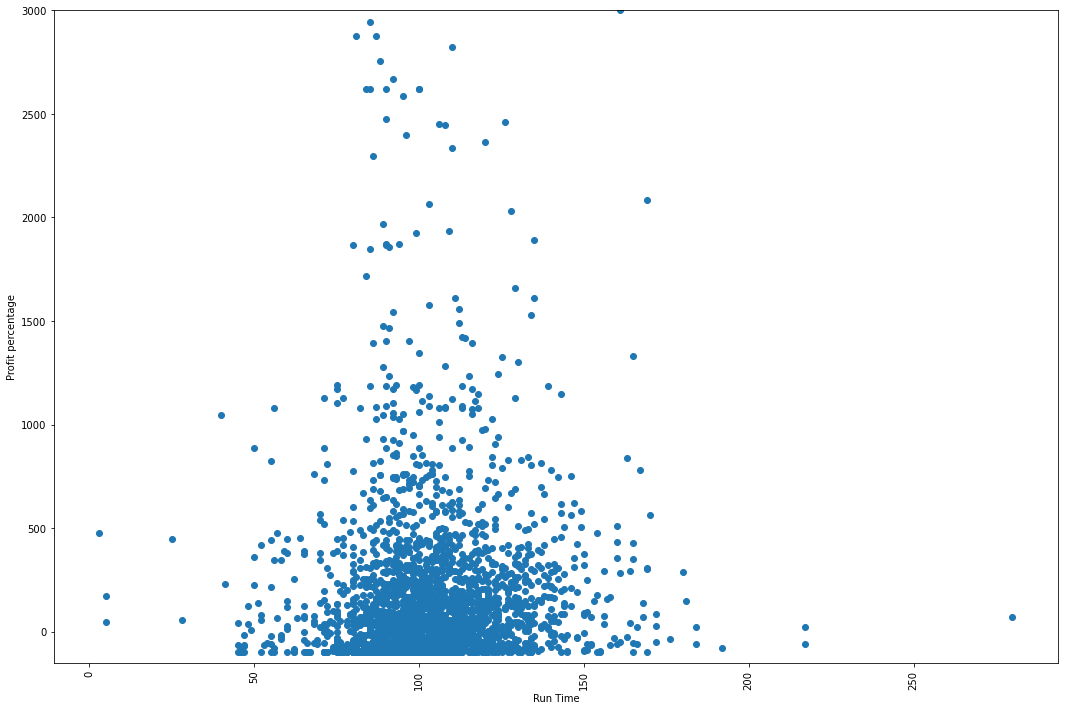

In [47]:
#plotting runtime vs profit percentage to see if there's an ideal movie length, overall looks like there's very little correlation
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['runtime_minutes']
y= maindf.profit_percentage

ax.set_xlabel('Run Time')
ax.set_ylabel('Profit percentage')
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)

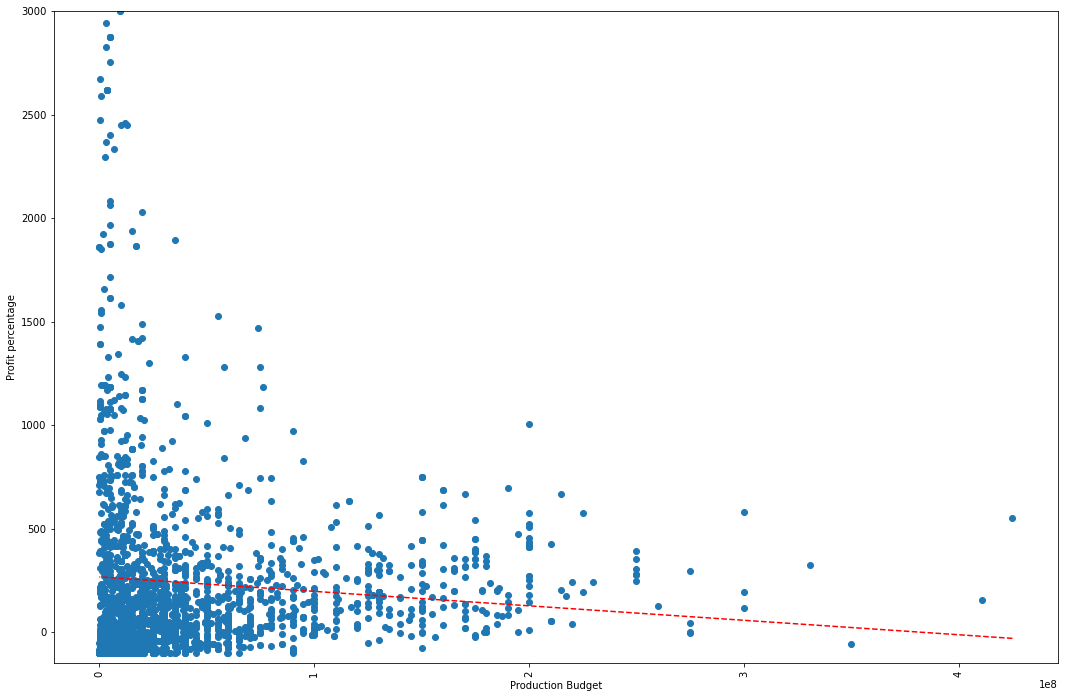

In [44]:
#plotting production budet vs. profit percentage to find ideal sweet spot of budget spent vs profit returned
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['production_budget']
y= maindf.profit_percentage
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
ax.set_xlabel('Production Budget')
ax.set_ylabel('Profit percentage')
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)

In [70]:
#calculating monthly average profit percentage to see which month is most profitable
maindf_monthnet = maindf.groupby(maindf['release_date'].dt.strftime('%B'))['profit_percentage'].mean().sort_values
maindf_monthnet

<bound method Series.sort_values of release_date
April        519.791219
August       178.273904
December     125.513440
February     167.801968
January      462.727233
July         476.094413
June         191.383599
March        143.617886
May          157.992568
November     190.434854
October      264.299660
September    151.592966
Name: profit_percentage, dtype: float64>

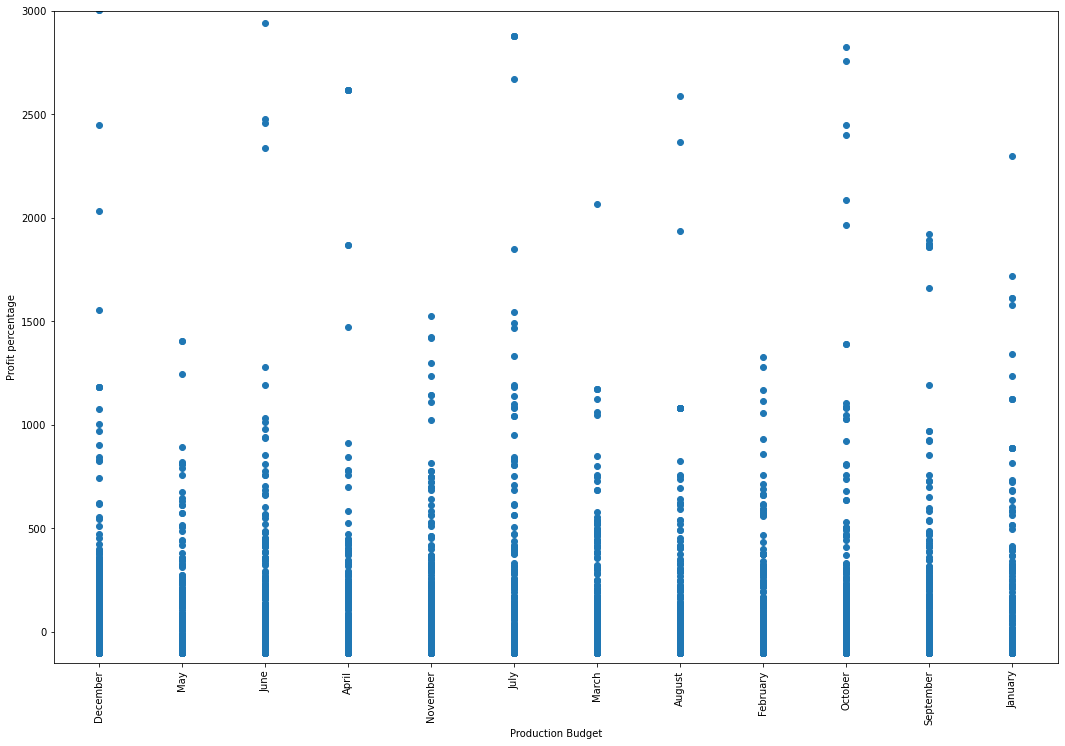

In [69]:
#convert to a bargraph? and then change x to be chronologically in order
fig, ax = plt.subplots(figsize= (18, 12))
x= maindf['release_date'].dt.strftime('%B')
y= maindf['profit_percentage']

ax.set_xlabel('Production Budget')
ax.set_ylabel('Profit percentage')
plt.xticks(rotation= 90)
ax.set_ylim(-150, 3000)
plt.scatter(x,y)

In [ ]:
# A couple of things to note since the last push-

# I reframed the data between the two Rotten Tomatoes databases to get rid of repeat data and fix some of the distributions. It's much shorter and much improved.

# I merged the budgets and imdb dataframes so we could graph the ratings against revenue which produced a much clearer picture. The downside is that the budgets dataset is heavily weighted to the last 10 years whereas the imdb one has a bit more spread. We may need to subset the data and just look at that short time frame, though I do feel good about that amount of data.

# The last data cleaning task is figuring out how to work with the genre data, which I feel we're pretty close to a breakthrough on. Once we do that, we should focus on visualizations, hypothesis testing and our presentation. 

# A basic idea of our next two days- 

# - finish parsing genre data
# -complete data visualizations weighing revenue against date, genre and rating 
# -generate more statistical data and examine the variance, correlation and deviation of our datasets
# -hypothesis test
# -create our presentation



In [ ]:
# ideally, i'd want to create a chart (maybe bar chart) that plots average rating based off the value in the list of genres